<center>
<a href="https://www.vision.rwth-aachen.de/">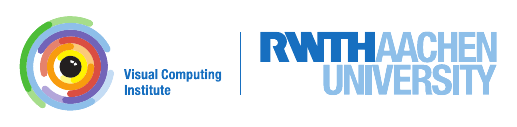</a>
</center>

# Advanced Machine Learning Excercises

**Assistants:**
<br>
Alexey Nekrasov &lt;nekrasov@vision.rwth-aachen.de&gt;
<br>
Jens Piekenbrinck &lt;piekenbrinck@vision.rwth-aachen.de&gt;

The assignments are **NOT** mandatory, but we still encourage you to work on them, in order to gain a deeper understanding.

We want to provide you with an interactive learning experience, so the assignments rely on [Jupyter](https://jupyter.org/) notebooks which you can run locally on your computer. The RWTH also offers a [JupyterHub](jupyter.rwth-aachen.de/) where you can run notebooks. If you have any questions, please contact us.

Make sure you fill in any place in *code cells* that says:
```python
# YOUR CODE HERE
raise NotImplementedError()
```

Make sure you fill in any place in *text cells* that says:
<br>

`YOUR ANSWER HERE`


### Submission:
Before submission remove outputs from the notebooks to prevent sending large files.
With images a hundred submissions could occupy a few GB of space.
To erase the outputs before submission, use a tool [nbstripout](https://github.com/kynan/nbstripout).

Upload all the notebook files with your changes to moodle. **IMPORTANT**: Do not rename files.

⏰ Due date: 2024-06-24 23:59:00

# Exercise 3: Sampling

## Table of Contents
<ul style="list-style:none;">
    <li>
        <a href="#1)-Sampling-Warming-Up">1) Sampling Warming Up</a>
    </li>
    <li>
        <a href="#2)-Rejection-Sampling-and-Transformation-Method">2) Rejection Sampling and Transformation Method</a>
        <ul>
            <li>
                <a href="#2a)-Rejection-Sampling">a) Rejection Sampling</a>
            </li>
            <li>
                <a href="#2b)-Transformation-Method">b) Transformation Method</a>
            </li>
        </ul>
    </li>
    <li>
        <a href="#3)-Importance-Sampling">3) Importance Sampling</a>
    </li>
    <li>
        <a href="#4)-Metropolis-Hasting-(MH)">4) Metropolis Hasting (MH)</a>
        <ul>
            <li>
                <a href="#4a)-Random-Walk">a) Random Walk</a>
            </li>
            <li>
                <a href="#4b)-Gaussian">b) Gaussian</a>
            </li>
        </ul>
    </li>
</ul>

Required packages for this exercise:
```bash
pip install matplotlib==3.8.4 numpy==1.26.4 seaborn==0.13.2
```
these are the specific versions that were used to create the exercise, newer versions may also be compatible.
If you encounter any issues, check the versioning of the packages.

In [2]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
from IPython.display import Latex

## 1) Sampling Warming Up
Lets start with a simple sampling example.

Suppose that the function `bad_rand()` produces random samples on the interval $[0, 1]$, but not quite as well as `rand()` does:
- $70\%$ of the time, `bad_rand()` produces a value that's uniformly distributed between $0$ and $0.5$.
- The other $30\%$ of the time, it produces a uniformly distributed value between $0.5$ and $1.0$.

The probability density for `bad_rand()` is shown in Figure 1(a).

|<img style="width:350px;" src="bad_rand.png" alt="(a) before">|<img style="width:350px;" src="good_rand.png" alt="(b) after">|
|------|------|
|<div style="text-align:center;"> (a) before </div>|<div style="text-align:center;"> (b) after |

<p style="text-align:center;">Figure 1</p>


Adjust the samples drawn from the `bad_rand()` such that the resulting distribution is uniform on $[0, 1]$ as in the right-hand side of Figure 1(b).
For sampling from `bad_rand()` use the following python function:

In [12]:
def sample_bad_rand(n):
    samples = []
    for i in range(1, n):
        if np.random.rand() < 0.7:
            x = np.random.rand() / 2
        else:
            x = 0.5 + np.random.rand() / 2
        samples.append(x)
    return samples

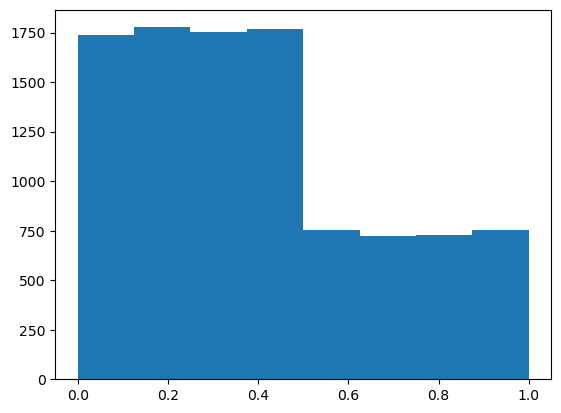

In [14]:
n = 10000
np.random.seed(42)
bad_rand = sample_bad_rand(n)

# Plotting a histogram of bin size 8 from the values obtained using bad_rand()
plt.hist(bad_rand, bins=8)
plt.show()

Adjust the random values obtained earlier, stored in `bad_rand`, such that the values would be distributed uniformly.

*Hint: reverse the operations of `sample_bad_rand()`.*

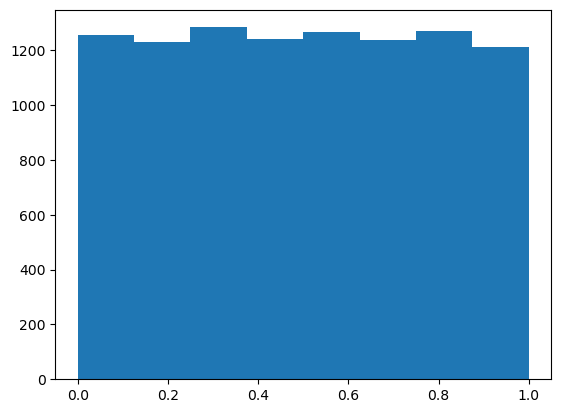

In [26]:
np.random.seed(42)


# def sample_bad_rand(n):
#     samples = []
#     for i in range(1, n):
#         if np.random.rand() < 0.7: 
            # x = u/2
#             x = np.random.rand() / 2
#         else:
            # x = 0.5 + u/2
#             x = 0.5 + np.random.rand() / 2 
#         samples.append(x)
#     return samples

def transform_bad_rand(bad_rand):
    good_rand = []

    # YOUR CODE HERE
    for x in bad_rand:
        # 0<u<0.7의 경우, 역변환 식: u = x * 2 * 0.7 (70%의 확률로 해당 구간에 속함)
        if x < 0.5:
            transform_u = x * 2 * 0.7
        else:
            # 그 외의 경우, 역변환 식: 0.7 + (x-0.5) * 2 * 0.3 (30%의 확률로 해당 구간에 속함)
            transform_u = 0.7 + (x - 0.5) * 2 * 0.3
        good_rand.append(transform_u)
    return good_rand


plt.hist(transform_bad_rand(bad_rand), bins=8)
plt.show()

#### Question: If the bad_rand value would be 0.3, what would be the value after transformation to good_rand?

In [28]:
# YOUR CODE HERE
# bad_rand value = 0.3 < 0.5
# transform_u = 0.3 * 2 * 0.7 = 0.42

# raise NotImplementedError()

## 2) Rejection Sampling and Transformation Method
Suppose we want to generate points between $0$ and $1$ where the probability density of selection $x$ is e.g.
$f_{X}(x) = 2x^{2}$. In the lecture you've learned a number of approaches, that could be used for this task.

### 2a) Rejection Sampling

At first lets recap the rejection sampling algorithm:
  1. Draw $x$ from an uniform distribution on [0, 1]
  2. Draw another value s from an uniform distribution on [0, 2]
  3. If $s < f_{X}(x)$, keep $x$; otherwise reject and start again by step 1

Implement the Rejection Sampling algorithm as described above.

In [30]:
iterations = 10000
np.random.seed(42)
accepted_samples = []
rejected_samples = []

# YOUR CODE HERE
# f(x) = 2 * x **2
for _ in range(iterations):
    x = np.random.uniform(0.0, 1.0)
    f_x = 2 * x**2
    s = np.random.uniform(0.0, 2.0)
    if s < f_x:
        accepted_samples.append(x)
    else:
        rejected_samples.append(x)
    


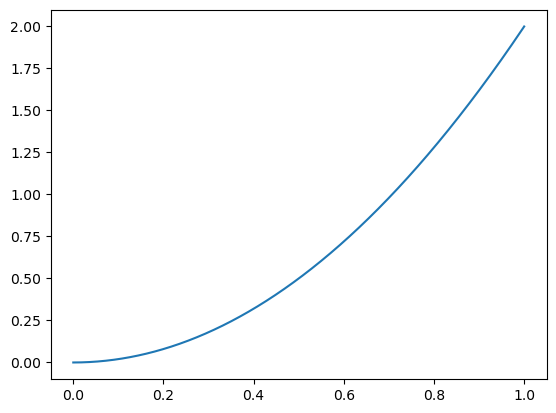

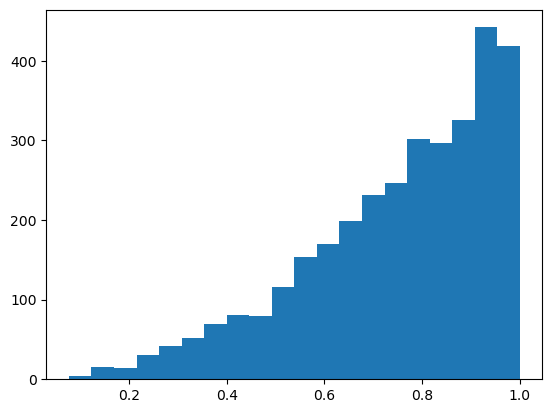

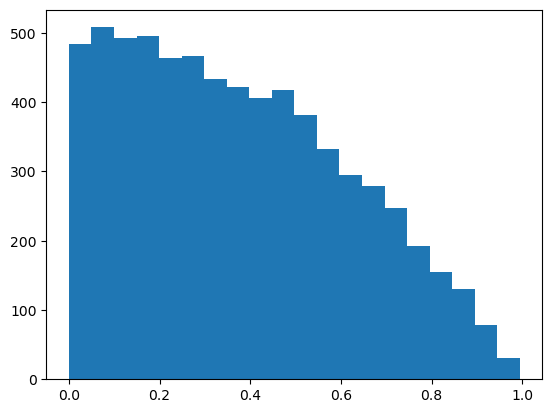

In [32]:
# Historgram plots of accepted and rejected samples
x = np.linspace(0, 1, 1000)
y = 2 * x**2
plt.plot(x, y)
plt.show()

plt.hist(accepted_samples, bins=20)
plt.show()

plt.hist(rejected_samples, bins=20)
plt.show()

#### Question: What is the ratio between accepted samples and rejected samples?

In [36]:
# YOUR CODE HERE
# rejection ratio = target_funtion / envelope function
ratio = np.random.uniform(0.0, 1.0) / np.random.uniform(0.0, 2.0)
print(ratio)


0.26130696051375335


### 2b) Transformation Method
Since we use a very simple PDF $f_{X}(x) = 2x^2$, we can also use transformation method for generating samples.

The corresponding cumulative distribution
$$F(x) = \int_{-\infty}^{x} f_{X}(z)$$ 

can easily be computed. To draw samples from this pdf, we just need to invert the cumulative distribution function:

$$u \thicksim \textit{Uniform}(0, 1) \rightarrow F^{-1}(u) \thicksim f(x)$$

Implement the Transformation method for generating samples of the proposed PDF $f_{X}(x)$.

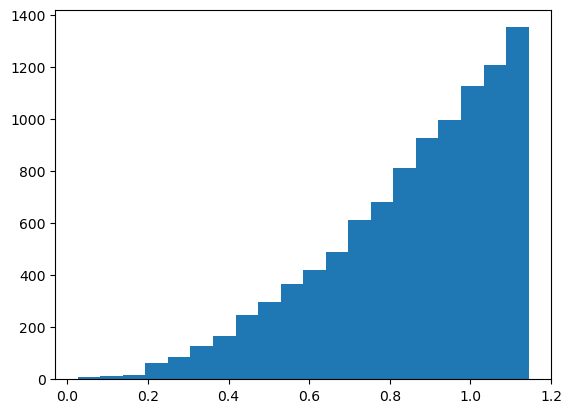

In [42]:
n = 10000
np.random.seed(42)


# To draw samples from f(x) = 2x^2, invert the cumulative distribution function to F^-1.
def sample_inv_cdf(u: np.array) -> np.array:
    # YOUR CODE HERE
        # F = (2/3) * x^3
        # x = F_inv
        return ((3/2) * u)**(1/3)


# Draw `n` samples from F^-1.
u = np.random.rand(n)
samples = sample_inv_cdf(u)

# Plotting the drawn samples
plt.hist(samples, bins=20)
plt.show()

#### Question: If you're sampling $u=0.3$ from the $\textit{Uniform}(0,1)$ distribution, what value do you get from the inverted cumulative distribution function, i.e. what is $F^{-1}(0.3)$?

In [44]:
# YOUR CODE HERE
u = 0.3
f_inv = ((3/2) * u)**(1/3)
print(f_inv)



0.7663094323935531


## 3) Importance Sampling
We will now turn to Importance Sampling. Remember, this is not a method to generate samples from the distribution directly, but a method to estimate the expectation. It can be viewed as a generalization of the uniform sampling method. In this exercise you should compute the expectation of the following function:

$$
f(x) = \left \{
    \begin{array}{ll}
        \frac{1}{100}\sqrt{x} & \text{if } x > 0\\
        0 & \text{otherwise.}
    \end{array}
\right.
$$

under the following target distribution:

$$p(x) = w_{1}N(x|\mu_{1}, \sigma_{1}) + w_{2}N(x|\mu_{2}, \sigma_{2})$$

using as proposal distribution:

$$g(x) = N(x|\mu, \sigma)$$

<br>

Implement importance sampling using the following values for the parameters:

$$w_{1} = 0.3, \mu_{1} = 0, \sigma_{1} = 2$$
$$w_{2} = 0.7, \mu_{2} = 10, \sigma_{2} = 2$$
$$\mu = 3, \sigma = 10$$

<img src="importance_sampling.png" alt="Importance sampling"/>
<p style="text-align:center;">
    Figure 2: <span style="color:blue;">Blue</span>: target distribution, <span style="color:red;">Red</span>: proposal distribution, <span style="color:magenta;">Magenta</span>: target function
</p>

In [46]:
# Target distribution parameters
weight1 = 0.3
mu1 = 0
sigma1 = 2

weight2 = 0.7
mu2 = 10
sigma2 = 2


# Proposal distribution parameters
mu_prop = 3
sigma_prop = 10

In [58]:
# Define the target function f(x)
def target_func(x: np.array) -> np.array:
    # YOUR CODE HERE
        return np.where(x > 0, (1/100) * np.sqrt(x), 0)


In [52]:
def gaussian(x: np.array, mu: float, sigma: float) -> np.array:
    # YOUR CODE HERE
    normal = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - mu)**2 / (2 * sigma**2))
    return normal

In [54]:
def mix_of_two_gaussians(
    x: np.array,
    weight1: float,
    mu1: float,
    sigma1: float,
    weight2: float,
    mu2: float,
    sigma2: float,
) -> np.array:
    # YOUR CODE HERE
    p = weight1 * gaussian(x, mu1, sigma1) + weight2 * gaussian(x, mu2, sigma2)
    return p


C:\Users\User\AppData\Local\Temp\ipykernel_20812\768484089.py:4: RuntimeWarning: invalid value encountered in sqrt
  return np.where(x > 0, (1/100) * np.sqrt(x), 0)


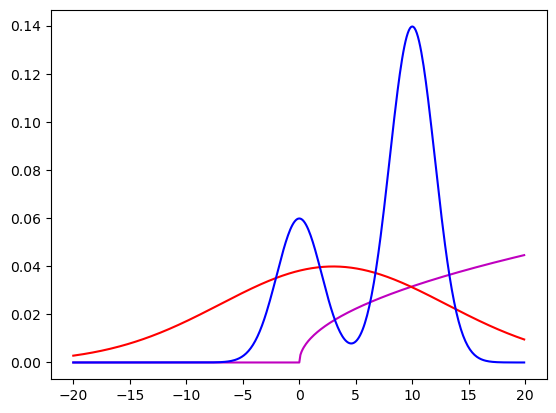

In [60]:
# Plotting the target distribution, target function and proposal distribution for real valued numbers in x.

# Visualization, x from -20 to 20 in steps of 0.1
x = np.arange(-20, 20, 0.1)

# Target function
target = target_func(x)

# Proposal distribution
proposal = gaussian(x, mu_prop, sigma_prop)

# Creating the target distribution p(x) which is a MoG
mog = mix_of_two_gaussians(x, weight1, mu1, sigma1, weight2, mu2, sigma2)

# Plotting the target function f(x), proposal distribution and the target distribution
plt.plot(x, target, "m-")
plt.plot(x, proposal, "r-")
plt.plot(x, mog, "b-")
plt.show()

What if $p(x)$ is very hard to sample from?

Then we estimate the expectation based on some known and easily sampled distribution $q(x)$, and $\frac{p(x)}{q(x)}$ is called sampling ratio or sampling weight, which acts as a correction weight to offset the probability sampling from a different distribution.

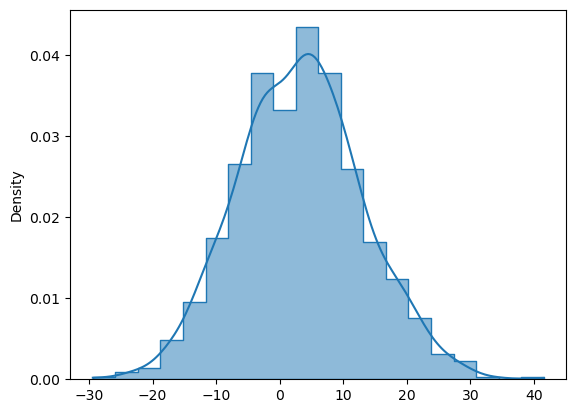

In [62]:
it = 1000  # no. of samples
np.random.seed(42)

qz = np.random.normal(mu_prop, sigma_prop, size=it)
# The samples of qz are then used to generate gaussian distributed values
qzValue = gaussian(qz, mu_prop, sigma_prop)
pSamples = mix_of_two_gaussians(qz, weight1, mu1, sigma1, weight2, mu2, sigma2)


# Plotting the samples obtained from a known normal distribution
sns.histplot(qz, bins=20, stat="density", kde=True, element="step")
plt.show()

####  Question: What is the expectation of function $f(x)$ under the distribution $p(x)$?

In [64]:
# YOUR CODE HERE
import scipy.integrate as integrate

def integrand(x):
    return target_func(x) * mix_of_two_gaussians(x, weight1, mu1, sigma1, weight2, mu2, sigma2)

expectation, _ = integrate.quad(integrand, -np.inf, np.inf)
print(expectation)

0.023764671996730477


C:\Users\User\AppData\Local\Temp\ipykernel_20812\768484089.py:4: RuntimeWarning: invalid value encountered in sqrt
  return np.where(x > 0, (1/100) * np.sqrt(x), 0)


## 4) Metropolis Hasting (MH)
The aim of this exercise is to illustrate the Metropolis Hasting (MH) algorithm by applying it to a simple
model.

### 4a) Random Walk
Given is the following target distribution:

$$p(x) = \frac{1}{\sqrt{2\pi\sigma}}exp (-\frac{1}{2\sigma^{2}}(x - \mu)^{2})$$

Implement the MH algorithm to generate samples from the proposed target distribution using as proposal distribution $q(x|x')$, a random walk kernel whose initial position x is defined as:

$$x \thicksim Uniform(x' -\frac{h}{2} , x' + \frac{h}{2}).$$
Let $\mu = 0$, $\sigma^{2} = 1$, $h = 1$.
1. Use your implementation to generate 10000 MH-updates.
2. Make a histogram of the sampled values and compare to the true distribution.

In [108]:
def MH(target, proposal, proposal_conditional, n_iterations: int):
    samples = []
    n_accepted = 0
    mu = 0
    sigma = 1
    h = 1

    # initial state
    x = np.random.rand()
    proposal_old = target(x)

    for i in range(n_iterations):
        xprime = proposal(x)

        # P(x')
        # P(x') / P(x)
        # q(x|x’), q(x'|x)
        target_new = target(xprime)
        target_old = target(x)
        proposal_new = proposal_conditional(x, xprime)
        proposal_old = proposal_conditional(xprime, x)
        
        # YOUR CODE HERE
        alpha = (target_new * proposal_old) / (target_old * proposal_new)
        alpha = min(1, alpha)

        # Acceptance probability A “accepts” the proposed value x'
        # otherwise rejects it by keeping the current value x
        if np.random.rand() <= alpha:
            x = xprime
            proposal_old = proposal_new
            n_accepted += 1

        if i > 2000:
            samples.append(x)

    return samples, n_accepted

In [110]:
def target(x, mu, sigma):
    # YOUR CODE HERE
    return (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - mu)**2 / (2 * sigma**2))


def proposal(x, h):
    # sample from q
    # YOUR CODE HERE
    return np.random.uniform(x - h/2, x + h/2)

def proposal_conditional(x, xprime, h):
    # compute q(x|x')
    # YOUR CODE HERE
    if x - h/2 <= xprime <= x + h/2:
        return 1/h
    else: 
        return 0


number of accepted samples = 45096


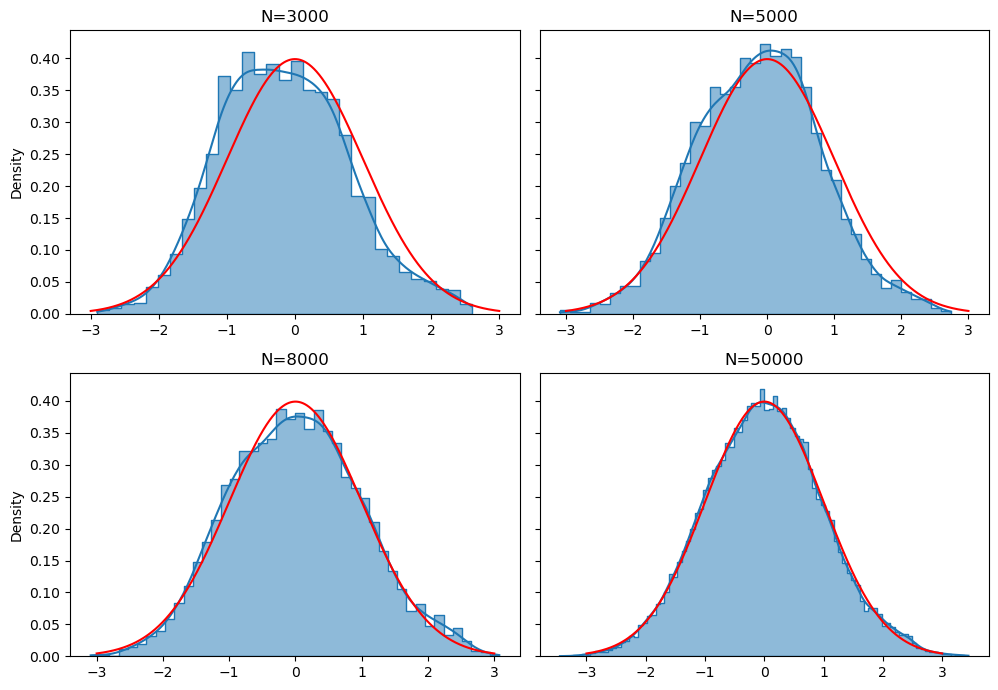

In [112]:
# Given data
np.random.seed(42)
n_iterations = 50000

# Collect the samples x (new positions) from the target distribution along with the acceptance count, naccept
target_fn = partial(target, mu=0, sigma=1)
proposal_fn = partial(proposal, h=1)
proposal_conditional_fn = partial(proposal_conditional, h=1)

x, naccept = MH(
    target=target_fn,
    proposal=proposal_fn,
    proposal_conditional=proposal_conditional_fn,
    n_iterations=n_iterations,
)

# Plot the histogram of samples drawn from the Target distribution
Ns = [3000, 5000, 8000, n_iterations]
print(f"number of accepted samples = {naccept}")

x_t = np.linspace(-3, 3, 1000)
gauss = target_fn(x_t)

fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharey=True)
for i, ax in enumerate(fig.axes):
    ax.set_title(f"N={Ns[i]}")
    sns.histplot(ax=ax, data=x[: Ns[i]], element="step", kde=True, stat="density")
    ax.plot(x_t, gauss, color="r")

plt.tight_layout()
plt.show()

### 4b) Gaussian
As next step use your MH implementation for sampling from a mixture of 1D Gaussian as given in
(3\) Importance Sampling:

$$p(x) = w_{1}N(x|\mu_{1}, \sigma_{1}) + w_{2}N(x|\mu_{2}, \sigma_{2})$$

using as proposal distribution:

$$g(x) = N(x|\mu, \sigma)$$

1. Use the paramater values that are given in (3).
2. Use your implementation to generate 10000 MH-updates.
3. Make a histogram of the sampled values and compare to the true distribution.

In [130]:
def target(
    x: np.array,
    weight1: float,
    mu1: float,
    sigma1: float,
    weight2: float,
    mu2: float,
    sigma2: float,
) -> np.array:
    # YOUR CODE HERE
    p = weight1 * gaussian(x, mu1, sigma1) + weight2 * gaussian(x, mu2, sigma2)
    return p


def proposal(mu: float, sigma: float) -> np.array:
    # sample from q
    # YOUR CODE HERE
    return np.random.normal(mu, sigma)


def proposal_conditional(x, xprime, h):
    # compute q(x|x')
    # YOUR CODE HERE
    if x - h/2 <= xprime <= x + h/2:
        return 1/h
    else: 
        return 0
    
def proposal_conditional(x: np.array, y: float, sigma_prop: float):
    # compute q(x | x')
    # YOUR CODE HERE
    prob = 1 / (sigma_prop * np.sqrt(2 * np.pi)) * np.exp(-(y - x)**2 / (2 * sigma_prop**2))
    return prob

number of accepted samples = 18171


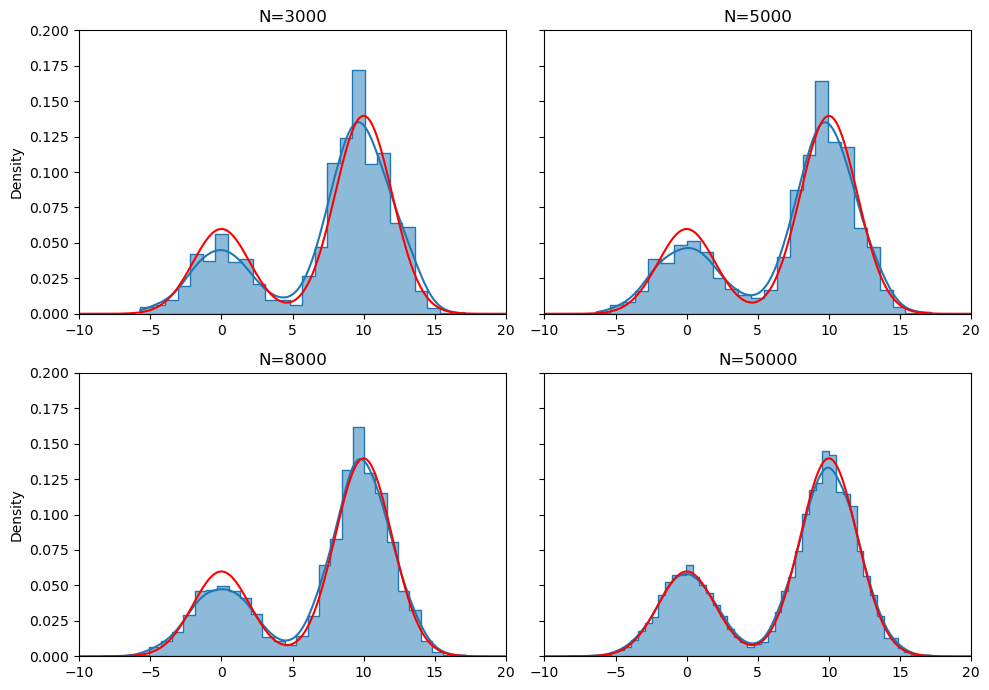

In [132]:
n_iterations = 50000
np.random.seed(42)

# Collect the samples x (new positions) from the target distribution along with the acceptance count, naccept
target_fn = partial(
    target,
    weight1=weight1,
    mu1=mu1,
    sigma1=sigma1,
    weight2=weight2,
    mu2=mu2,
    sigma2=sigma2,
)
proposal_fn = partial(proposal, sigma=sigma_prop)
proposal_conditional_fn = partial(proposal_conditional, sigma_prop=sigma_prop)

x, naccept = MH(
    target=target_fn,
    proposal=proposal_fn,
    proposal_conditional=proposal_conditional_fn,
    n_iterations=n_iterations,
)

# Plot the histogram of samples drawn from the Target distribution
Ns = [3000, 5000, 8000, n_iterations]
print(f"number of accepted samples = {naccept}")

x_t = np.linspace(-10, 20, 1000)
gauss = target_fn(x_t)

fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharey=True)
for i, ax in enumerate(fig.axes):
    ax.set_title(f"N={Ns[i]}")
    sns.histplot(ax=ax, data=x[: Ns[i]], element="step", kde=True, stat="density")
    ax.plot(x_t, gauss, color="r")
    ax.axis([-10, 20, 0, 0.2])

plt.tight_layout()
plt.show()